# Trabajo Práctico III - Ejercicio 2
### Fernando Ezequiel pose

## Librerías Generales

In [1]:
# for data load
import os

# for reading and processing images
import imageio
from PIL import Image
import cv2

# for visualizations
import matplotlib.pyplot as plt

import numpy as np # for using np arrays

# for bulding and running deep learning model
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

# Uso métrica MeanIou para ver proporción de detectado
from tensorflow.keras.metrics import MeanIoU

# Otras
import time

In [ ]:
# Dataset de las Grietas en el Concreto
!wget -c --no-check-certificate "https://drive.google.com/uc?export=download&id=1kEAeac5Bvp71JZE6MZIBT62yEpXo080J&confirm=t" -O concreto_agrietado_segmentacion.zip

In [3]:
# Descomprimir dataset
!unzip -qq concreto_agrietado_segmentacion.zip

<a name='2'></a>
# 2 - Helper Functions for Data Processing

<a name='2.1'></a>
## 2.1 - Load Data

* los nombres de las imagenes y las segmentaciones siguen el mismo patrón, por lo que para obtener la muestra correcta, podemos ordenar las 2 listas

In [7]:
def LoadData (path1, path2):
    """
    Looks for relevant filenames in the shared path
    Returns 2 lists for original and masked files respectively

    """
    # Read the images folder like a list
    image_dataset = os.listdir(path1)
    mask_dataset = os.listdir(path2)

    # Make a list for images and masks filenames
    orig_img = []
    mask_img = []
    for file in image_dataset:
        orig_img.append(file)
    for file in mask_dataset:
        mask_img.append(file)

    # Sort the lists to get both of them in same order (the dataset has exactly the same name for images and corresponding masks)
    orig_img.sort()
    mask_img.sort()

    return orig_img, mask_img

<a name='2.2'></a>
## 2.2 - Pre-Process Data

In [8]:
def PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2):
    """
    Processes the images and mask present in the shared list and path
    Returns a NumPy dataset with images as 3-D arrays of desired size
    Please note the masks in this dataset have only one channel
    """
    # Pull the relevant dimensions for image and mask
    m = len(img)                     # number of images
    i_h,i_w,i_c = target_shape_img   # pull height, width, and channels of image
    m_h,m_w,m_c = target_shape_mask  # pull height, width, and channels of mask

    # Define X and Y as number of images along with shape of one image
    X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)

    # Resize images and masks
    for file in img:
        # convert image into an array of desired shape (3 channels)
        index = img.index(file)
        path = os.path.join(path1, file)
        single_img = Image.open(path).convert('RGB')
        single_img = single_img.resize((i_h,i_w))
        single_img = np.reshape(single_img,(i_h,i_w,i_c))
        single_img = single_img/256.
        X[index] = single_img

        # convert mask into an array of desired shape (1 channel)
        single_mask_ind = mask[index]
        path = os.path.join(path2, single_mask_ind)
        single_mask = cv2.imread(path, 0)
        single_mask = cv2.resize(single_mask, (m_h, m_w))
        single_mask = np.reshape(single_mask,(m_h,m_w,m_c))
        single_mask = single_mask/101.      # Deja en 0 o en 1, la máscara. 2 clases, fondo y el objeto
        y[index] = single_mask
    return X, y

<a name='3'></a>
#3 - Constructing the U-Net Architecture


<a name='3.1'></a>
## 3.1 - U-Net Encoder Block

In [9]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning.
    Dropout can be added for regularization to prevent overfitting.
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow
    # Proper initialization prevents from the problem of exploding and vanishing gradients
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)

    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions
    skip_connection = conv

    return next_layer, skip_connection

<a name='3.2'></a>
## 3.2 - U-Net Decoder Block

In [10]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)

    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters,
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

<a name='3.3'></a>
## 3.3 - Compile U-Net Blocks

In [11]:
def UNetCompiled(input_size=(128, 128, 3), n_filters=32, n_classes=2):
    """
    Combine both encoder and decoder blocks according to the U-Net research paper
    Return the model as output
    """
    # Input size represent the size of 1 image (the size used for pre-processing)
    inputs = Input(input_size)

    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image
    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size.
    # Observe the number of channels will be equal to number of output classes
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

<a name='4'></a>
# 4 - Executing above Functions to Train the Model

<a name='4.1'></a>
## 4.1 - Load and View Data

<ipython-input-12-fd391cdc8bf0>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_view  = imageio.imread(path1 + img[i])
<ipython-input-12-fd391cdc8bf0>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask_view = imageio.imread(path2 + mask[i])


(227, 227, 3)
(227, 227, 3)
(227, 227, 3)
(227, 227, 3)
(227, 227, 3)
(227, 227, 3)


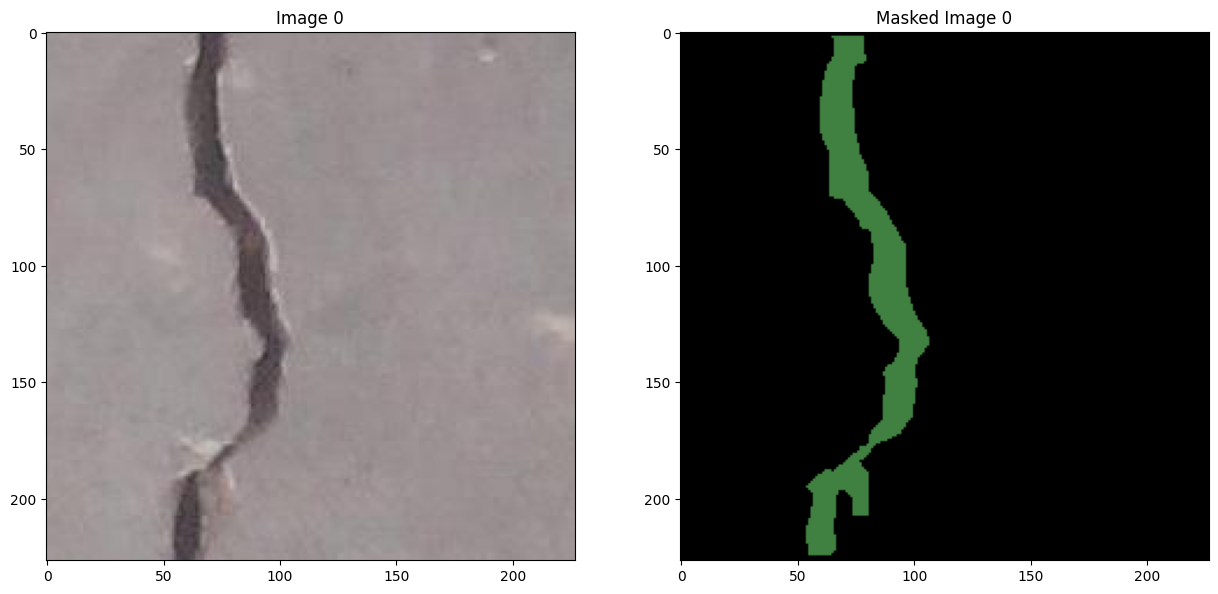

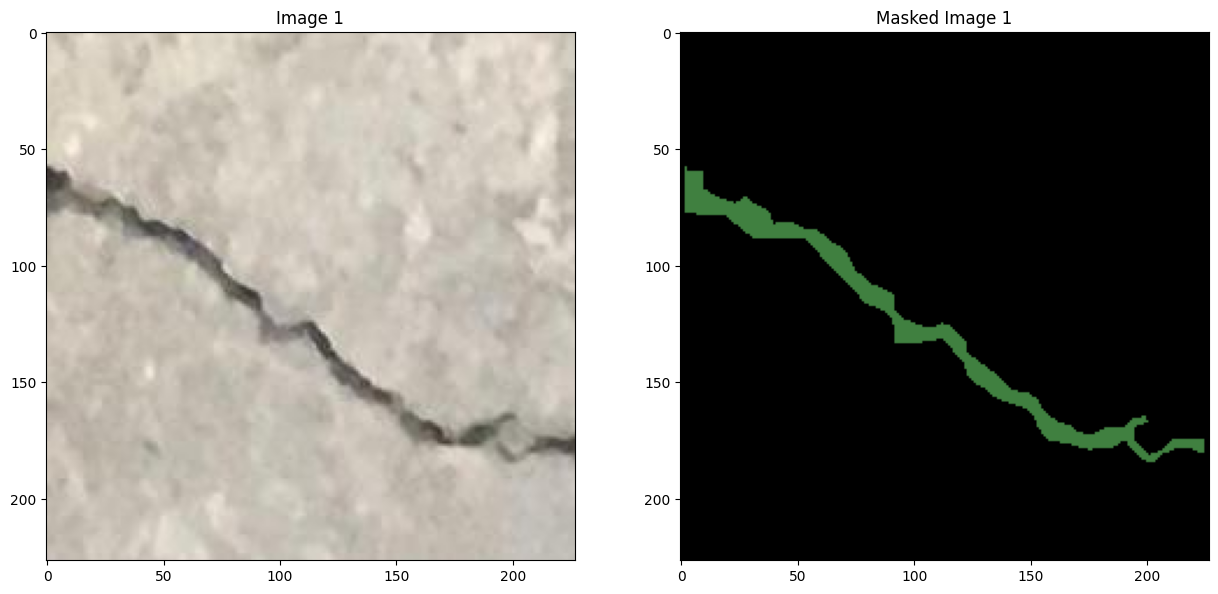

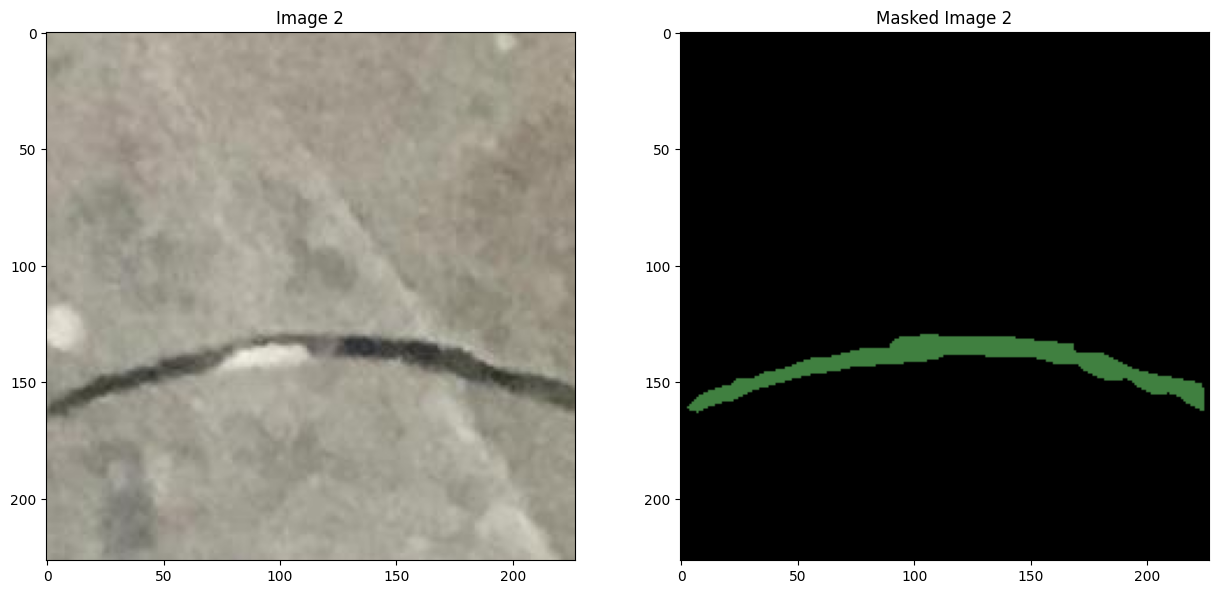

In [12]:
""" Load Train Set and view some examples """
# Call the apt function
path1 = '/content/cracks/'
path2 = '/content/labels/'
img, mask = LoadData(path1, path2)

# View an example of image and corresponding mask
show_images = 3
for i in range(show_images):
    img_view  = imageio.imread(path1 + img[i])
    mask_view = imageio.imread(path2 + mask[i])
    print(img_view.shape)
    print(mask_view.shape)
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(img_view)
    arr[0].set_title('Image '+ str(i))
    arr[1].imshow(mask_view)
    arr[1].set_title('Masked Image '+ str(i))

<a name='4.2'></a>
## 4.2 - Process Data

X Shape: (410, 128, 128, 3)
Y shape: (410, 128, 128, 1)
[0 1]


Text(0.5, 1.0, 'Processed Masked Image ')

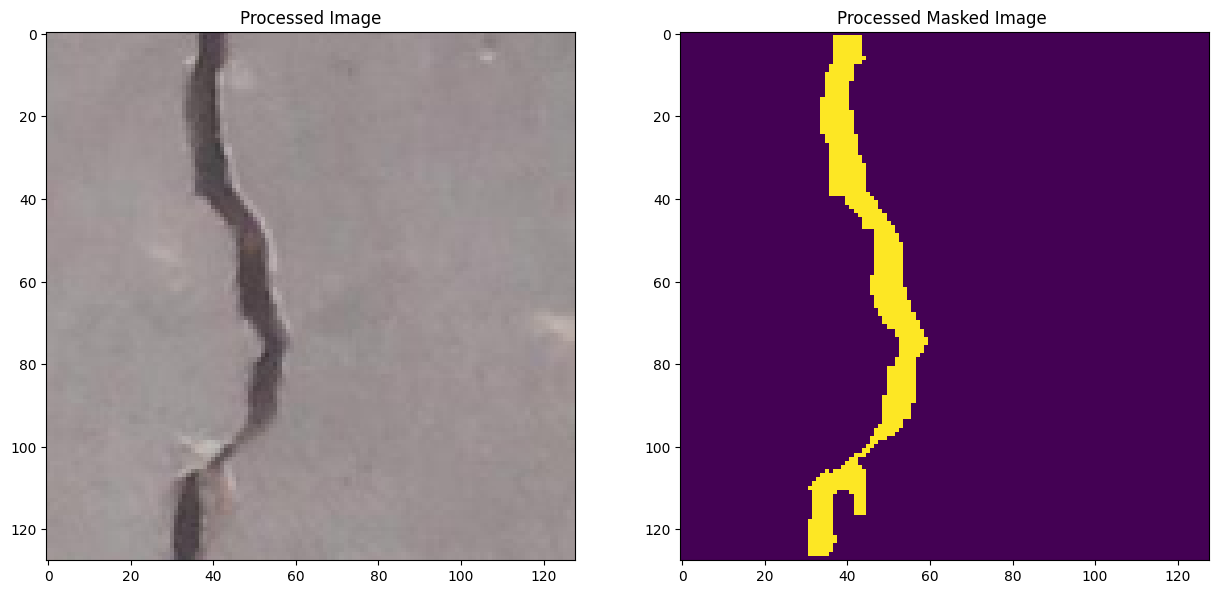

In [13]:
# Se define la nueva resolución, en este caso se baja de 227 a 128
target_shape_img = [128, 128, 3]    # 3 canales, RGB
target_shape_mask = [128, 128, 1]   # 1 canal la máscara, es o no es

# Process data using apt helper function
X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2)

# QC the shape of output and classes in output dataset
print("X Shape:", X.shape)
print("Y shape:", y.shape)
# Deberían haber 2 clases: fondo y la de interés.  ###### IMPORTANTE #######
print(np.unique(y))

# Visualize the output
image_index = 0
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(X[image_index])
arr[0].set_title('Processed Image')
arr[1].imshow(y[image_index,:,:,0])
arr[1].set_title('Processed Masked Image ')

## 4.3 - Split Train and Test Set

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)

<a name='4.4'></a>
## 4.4 - Build U-Net Architecture

In [15]:
# Se construye el modelo con las características deseadas
unet = UNetCompiled(input_size=(128,128,3), n_filters=32, n_classes=2)

In [16]:
# Check the summary to better interpret how the output dimensions change in each layer
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         128       ['conv2d_1[0][0]']            
 Normalization)                                                                               

<a name='4.5'></a>
## 4.5 - Compile and Run Model

In [17]:
# from tensorflow.keras.metrics import MeanIoU


# There are multiple optimizers, loss functions and metrics that can be used to compile multi-class segmentation models
# Ideally, try different options to get the best accuracy
unet.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.OneHotMeanIoU(num_classes=2, name="iou", sparse_y_pred=False),
                       tf.keras.metrics.KLDivergence(name="kld"),
                       'accuracy'])

In [18]:
# Run the model in a mini-batch fashion and compute the progress for each epoch
start_entrenamiento = time.time()
results = unet.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_valid, y_valid))      # Con GPU 1 m aprox. Con CPU 1 h.
fin_entrenamiento = time.time()

Epoch 1/20
11/11 [==============================] - 27s 843ms/step - loss: 0.3025 - iou: 0.4700 - kld: 1.2928 - accuracy: 0.8616 - val_loss: 0.2271 - val_iou: 1.0000 - val_kld: 1.5585 - val_accuracy: 0.9049
Epoch 2/20
11/11 [==============================] - 2s 214ms/step - loss: 0.2082 - iou: 0.5000 - kld: 1.4536 - accuracy: 0.9085 - val_loss: 0.2017 - val_iou: 0.5000 - val_kld: 1.5562 - val_accuracy: 0.9049
Epoch 3/20
11/11 [==============================] - 2s 215ms/step - loss: 0.1727 - iou: 0.4953 - kld: 1.2713 - accuracy: 0.9175 - val_loss: 0.4098 - val_iou: 0.4054 - val_kld: 0.7162 - val_accuracy: 0.8854
Epoch 4/20
11/11 [==============================] - 3s 231ms/step - loss: 0.2467 - iou: 0.4878 - kld: 1.3474 - accuracy: 0.9119 - val_loss: 0.2086 - val_iou: 0.4945 - val_kld: 1.4969 - val_accuracy: 0.9152
Epoch 5/20
11/11 [==============================] - 3s 231ms/step - loss: 0.1837 - iou: 0.4930 - kld: 1.4719 - accuracy: 0.9217 - val_loss: 0.1745 - val_iou: 0.4915 - val_kld:

In [19]:
print("Tiempo de entrenamiento: {:.4f} s".format(fin_entrenamiento-start_entrenamiento))

Tiempo de entrenamiento: 86.3273 s


<a name='5'></a>
# 5 - Evaluate Model Results

<a name='5.1'></a>
## 5.1 - Bias Variance Check

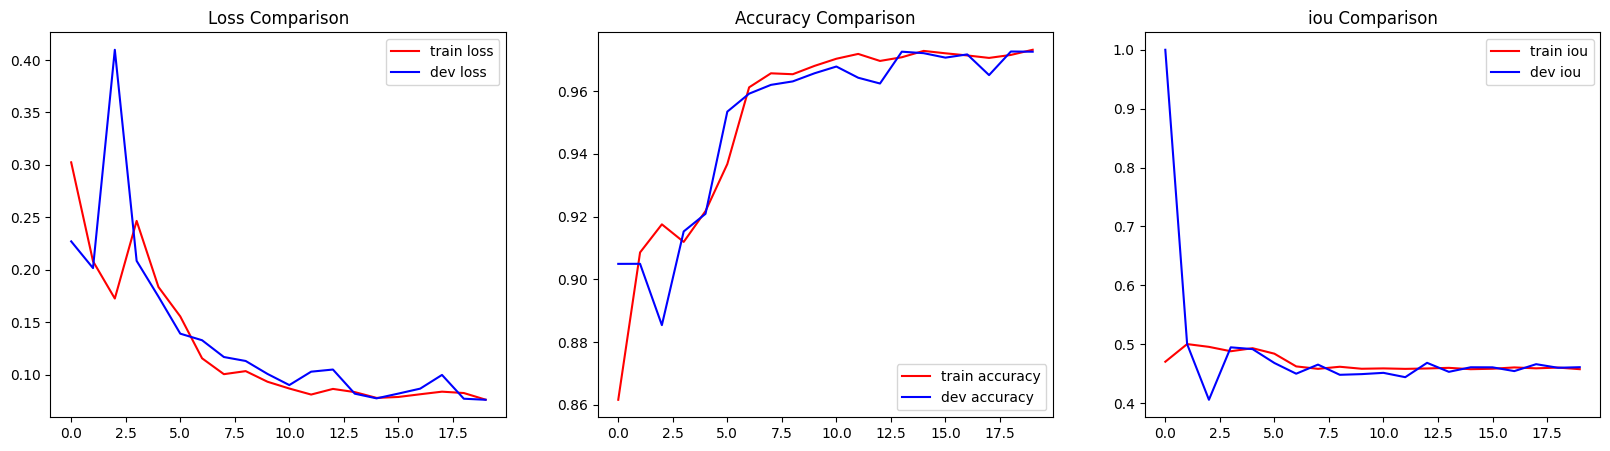

In [20]:
# High Bias is a characteristic of an underfitted model and we would observe low accuracies for both train and validation set
# High Variance is a characterisitic of an overfitted model and we would observe high accuracy for train set and low for validation set
# To check for bias and variance plit the graphs for accuracy
# I have plotted for loss too, this helps in confirming if the loss is decreasing with each iteration - hence, the model is optimizing fine
fig, axis = plt.subplots(1, 3, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'dev loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()

axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'dev accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()

axis[2].plot(results.history["iou"], color='r', label = 'train iou')
axis[2].plot(results.history["val_iou"], color='b', label = 'dev iou')
axis[2].set_title('iou Comparison')
axis[2].legend()

# RESULTS
# The train loss is consistently decreasing showing that Adam is able to optimize the model and find the minima
# The accuracy of train and validation is ~90% which is high enough, so low bias
# and the %s aren't that far apart, hence low variance

<a name='5.2'></a>
## 5.2 - View Predicted Segmentations

In [21]:
from skimage.measure import find_contours
from skimage.segmentation import mark_boundaries

# Results of Validation Dataset
def VisualizeResults(index):
    img = X_valid[index]
    img = img[np.newaxis, ...]

    # Prediccion de una imagen
    start_predict = time.time()
    pred_y = unet.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    end_predict = time.time()
    ##########################

    # Binarización de la máscara
    threshold = 0.5
    binary_mask = tf.cast(pred_mask[:,:,0] > tf.cast(threshold, pred_mask.dtype), pred_mask.dtype)

    # Busco los contornos con máscara binaria
    contours = find_contours(binary_mask.numpy(), 0.5)

    fig, arr = plt.subplots(1, 4, figsize=(15, 15))
    arr[0].imshow(X_valid[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(y_valid[index,:,:,0])
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(pred_mask[:,:,0])
    arr[2].set_title('Predicted Masked Image ')

    arr[3].imshow(X_valid[index])
    arr[3].imshow(mark_boundaries(X_valid[index], binary_mask, color=(1, 0, 0), mode='thick', outline_color=None), alpha=0.5)
    arr[3].set_title("Overlapping Predicted Mask")

    # Veo tiempo de predicción
    print("Tiempo de predicción de una imagen: {:.4f} s".format(end_predict-start_predict))

1/1 [==============================] - 1s 910ms/step
Tiempo de predicción de una imagen: 0.9728 s


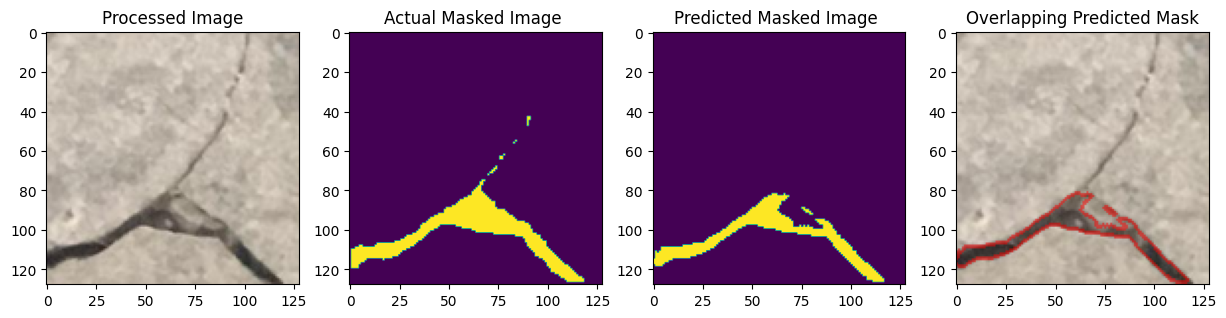

In [22]:
# Elegir índice para mostrar la imágen en cuestión: original escalada, máscara original escalada, máscara predicha
index = 7
VisualizeResults(index)

<a name='6'></a>
# 6 - Validación del Modelo sobre nuevas imágenes (Para las grietas - TP)

Breve sección para descargar el dataset propuesto de nuevas imágenes con grietas. Al extraer hay 2 directorios: `Positive` y `Negative`.

Se pueden visualizar las predicciones (segmentaciones) sobre algunas de las imágenes contenidas en esos directorios.

In [4]:
# Descargamos los nuevos datos para test
!wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/5y9wdsg2zt-2.zip -O concrete_cracks.zip

--2023-11-30 12:34:27--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/5y9wdsg2zt-2.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 3.5.64.192, 3.5.69.153, 3.5.67.189, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|3.5.64.192|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240847944 (230M) [application/octet-stream]
Saving to: ‘concrete_cracks.zip’

concrete_cracks.zip 100%[===================>] 229.69M  22.8MB/s    in 17s     

2023-11-30 12:34:45 (13.2 MB/s) - ‘concrete_cracks.zip’ saved [240847944/240847944]



In [5]:
!unzip -qq concrete_cracks.zip

In [6]:
!pip install unrar # Para descomprimir el .rar del dataset externo. Se instala librería

In [ ]:
!unrar x "Concrete Crack Images for Classification.rar"

# Visualizaciones sobre las imágenes CON GRIETAS

1/1 [==============================] - 0s 18ms/step


<ipython-input-27-6db84c12f8c3>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_view  = imageio.imread(path1 + img[i])  # Leemos la imagen tal cual, para graficarla


1/1 [==============================] - 0s 21ms/step


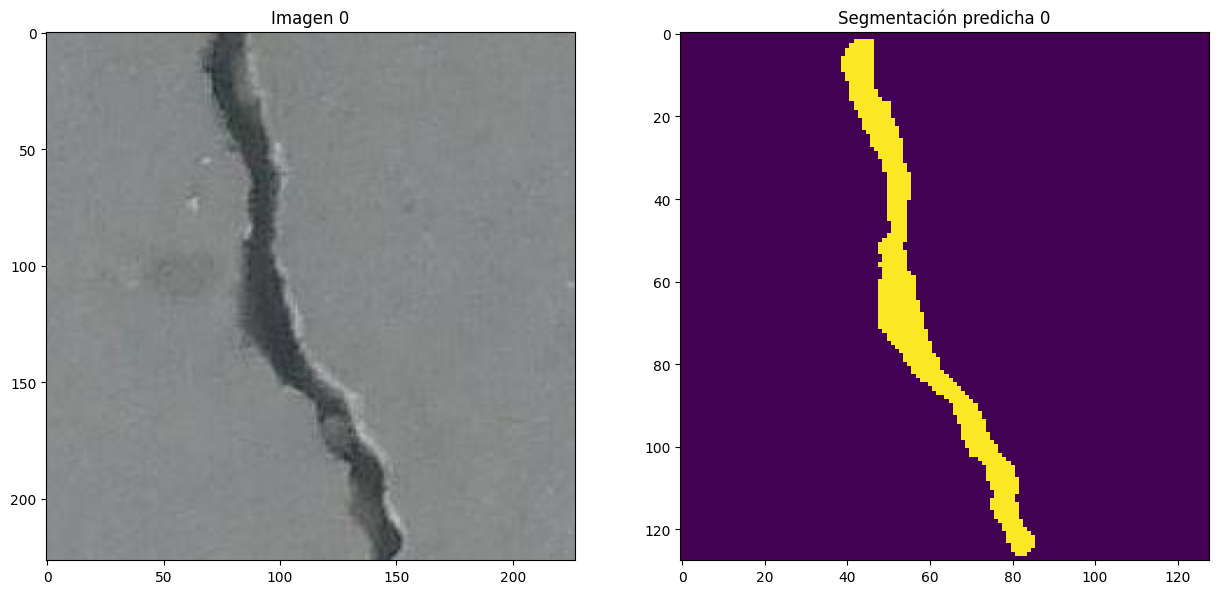

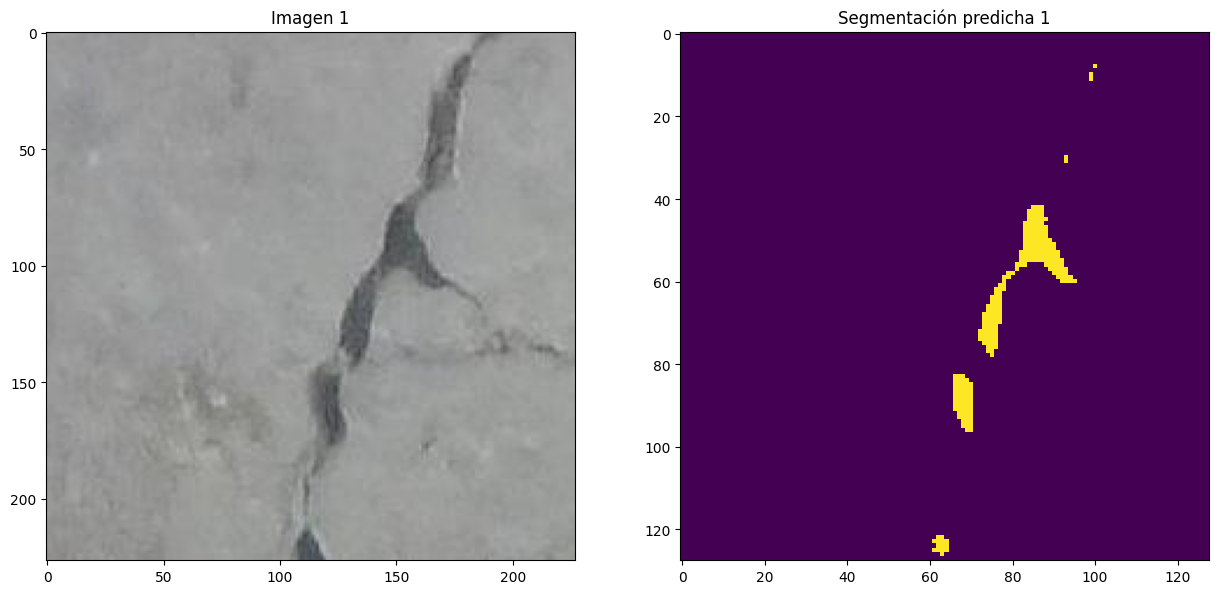

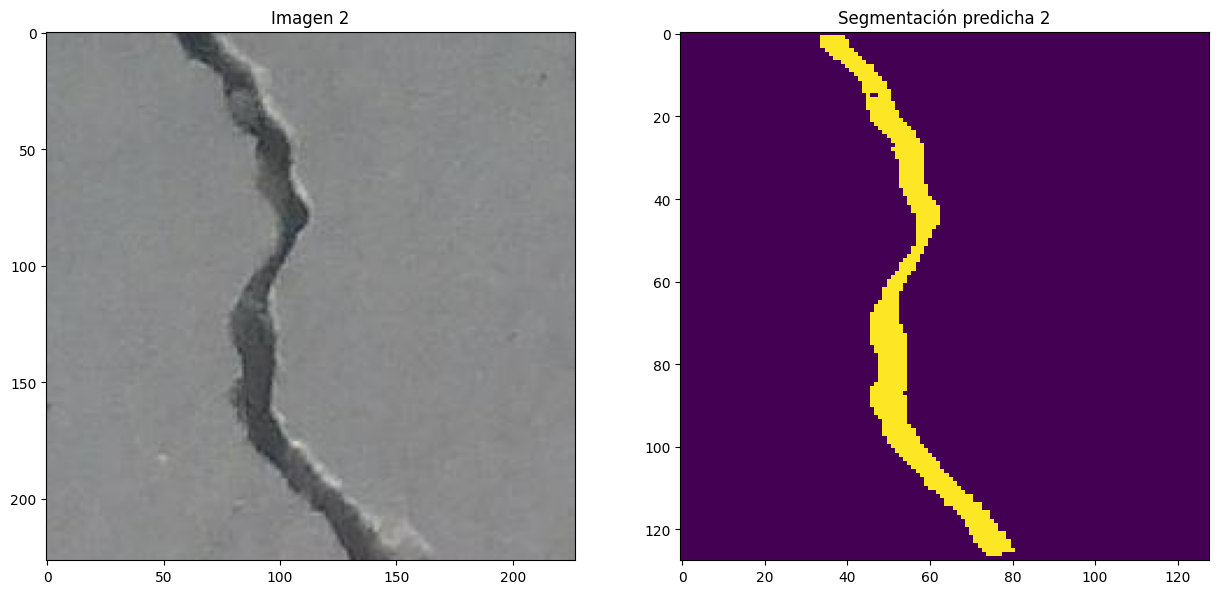

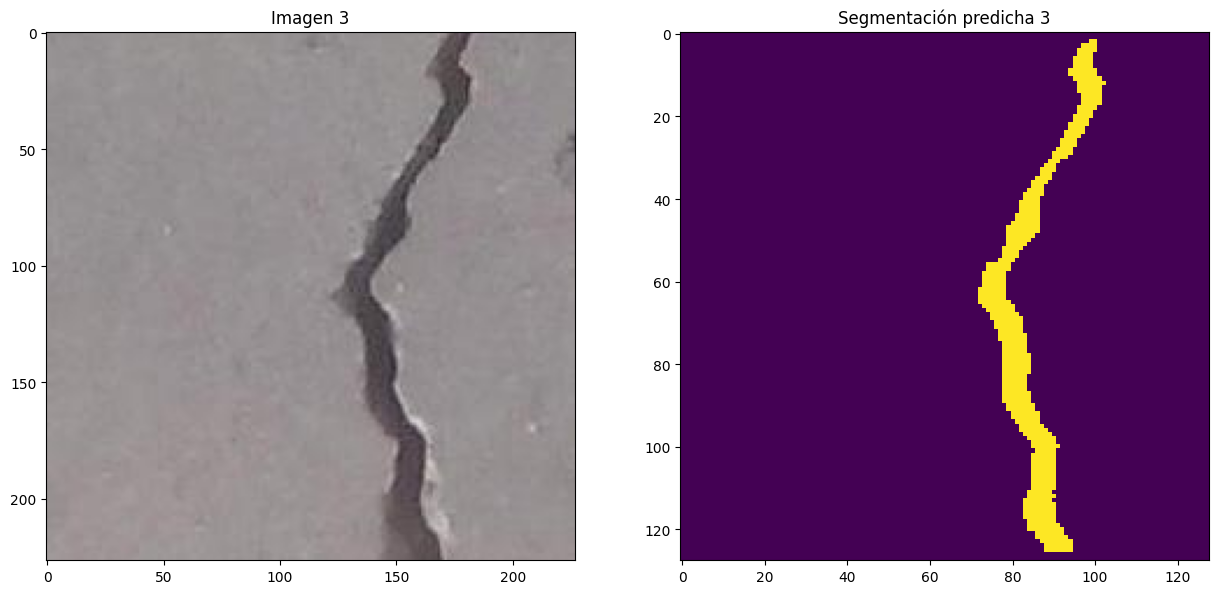

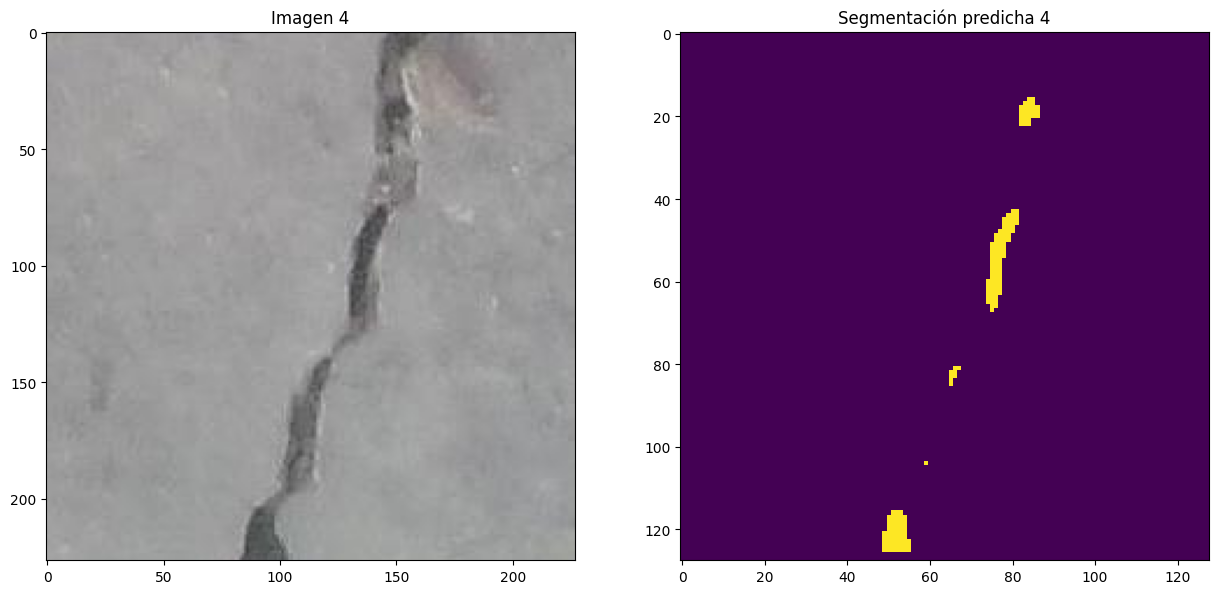

In [27]:
path1 = '/content/Positive/'  # Path de los nuevos datos, en esta carpeta hay cosas con "grietas"
path2 = '/content/labels/'
img, _ = LoadData(path1, path2) # Reciclo misma función de carga de antes, solo que la máscara ahora no tengo

show_images = 5   # Cantidad de imágenes a mostrar
for i in range(show_images):
    img_view  = imageio.imread(path1 + img[i])  # Leemos la imagen tal cual, para graficarla

    # Lectura de imagen y preprocesamiento para usarla en nuestro modelo (lo mismo que en la función para preprocesar)
    img_preprocesing = Image.open(path1 + img[i]).convert('RGB')
    img_preprocesing = img_preprocesing.resize((128,128))        # Rescalado, si usaron otro tamaño... cambiar acá
    img_preprocesing = np.reshape(img_preprocesing,(128,128,3))
    img_preprocesing = img_preprocesing/256.                     # Normalizado
    img_preprocesing = img_preprocesing[np.newaxis, ...]
    pred_y = unet.predict(img_preprocesing)                      # Prediccion del modelo
    # Transformaciones para poder graficar lo obtenido
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]

    # Ahora si, gráficas
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(img_view)
    arr[0].set_title('Imagen '+ str(i))
    arr[1].imshow(pred_mask)
    arr[1].set_title('Segmentación predicha '+ str(i))

Veo cuantas imagenes detecta con grieta y cuantas sin. Deberia detectar todas con grietas.

In [ ]:
# Inicializar contadores
imagen_predicha_con_grieta_con_umbral = 0
imagen_predicha_sin_grieta_con_umbral = 0
imagen_predicha_con_grieta_sin_umbral = 0
imagen_predicha_sin_grieta_sin_umbral = 0
UMBRAL = 20 # Cantidad de pixels

cant_img_analisis = 500

for i in range(cant_img_analisis):

    # Lectura de imagen y preprocesamiento para usarla en nuestro modelo (lo mismo que en la función para preprocesar)
    img_preprocesing = Image.open(path1 + img[i]).convert('RGB')
    img_preprocesing = img_preprocesing.resize((128, 128))  # Rescalado, si usaron otro tamaño... cambiar acá
    img_preprocesing = np.reshape(img_preprocesing, (128, 128, 3))
    img_preprocesing = img_preprocesing / 256.  # Normalizado
    img_preprocesing = img_preprocesing[np.newaxis, ...]

    pred_y = unet.predict(img_preprocesing)  # Predicción del modelo
    # Transformaciones para poder graficar lo obtenido
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]

    # Verifico si hay grietas (con umbral)
    if np.sum(pred_mask) < UMBRAL:
        imagen_predicha_con_grieta_con_umbral += 1
    else:
        imagen_predicha_sin_grieta_con_umbral += 1

    # Verifico si hay grietas (sin umbral)
    if np.sum(pred_mask) == 0:
        imagen_predicha_con_grieta_sin_umbral += 1
    else:
        imagen_predicha_sin_grieta_sin_umbral += 1

In [37]:
# Muestro resultados de conteo (con umbral)
print("Imágenes con grietas (con umbral): {} ({}%)".format(imagen_predicha_con_grieta_con_umbral, (imagen_predicha_con_grieta_con_umbral/cant_img_analisis) * 100))
print("Imágenes sin grietas (con umbral): {} ({}%)".format(imagen_predicha_sin_grieta_con_umbral, (imagen_predicha_sin_grieta_con_umbral/cant_img_analisis) * 100))

# Muestro resultados de conteo (sin umbral)
print("Imágenes con grietas (sin umbral): {} ({}%)".format(imagen_predicha_con_grieta_sin_umbral, (imagen_predicha_con_grieta_sin_umbral/cant_img_analisis) * 100))
print("Imágenes sin grietas (sin umbral): {} ({}%)".format(imagen_predicha_sin_grieta_sin_umbral, (imagen_predicha_sin_grieta_sin_umbral/cant_img_analisis) * 100))

Imágenes con grietas (con umbral): 461 (92.2%)
Imágenes sin grietas (con umbral): 39 (7.8%)
Imágenes con grietas (sin umbral): 394 (78.8%)
Imágenes sin grietas (sin umbral): 106 (21.2%)


# Visualizaciones sobre las imágenes SIN GRIETAS

1/1 [==============================] - 0s 19ms/step


<ipython-input-38-73bd69b2f209>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_view  = imageio.imread(path1 + img[i])  # Leemos la imagen tal cual, para graficarla


1/1 [==============================] - 0s 22ms/step


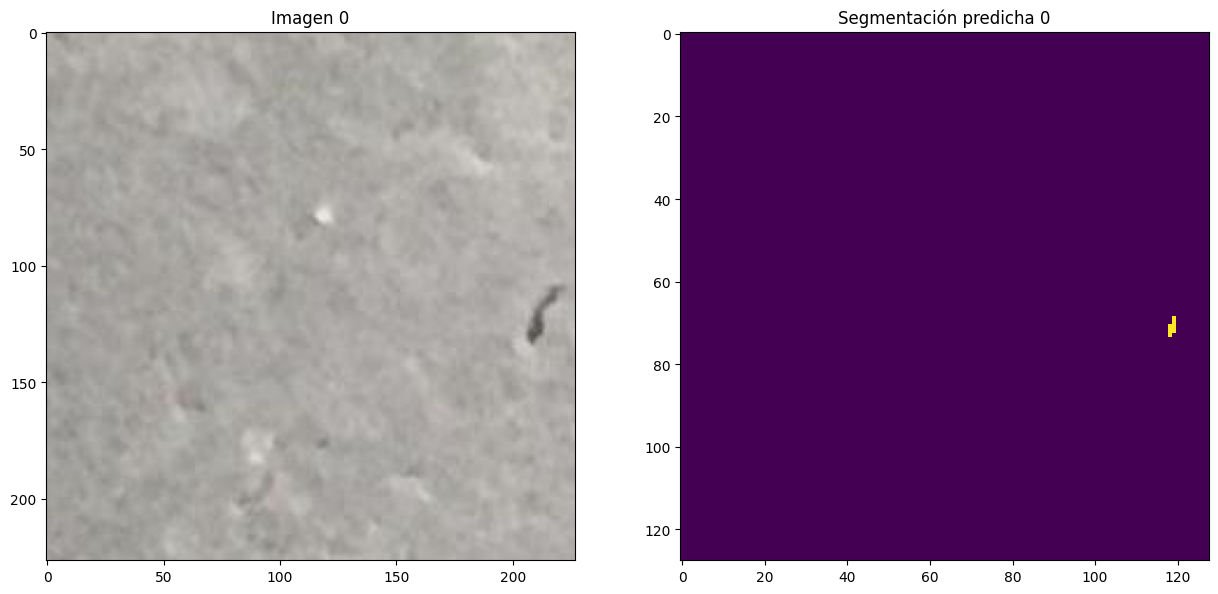

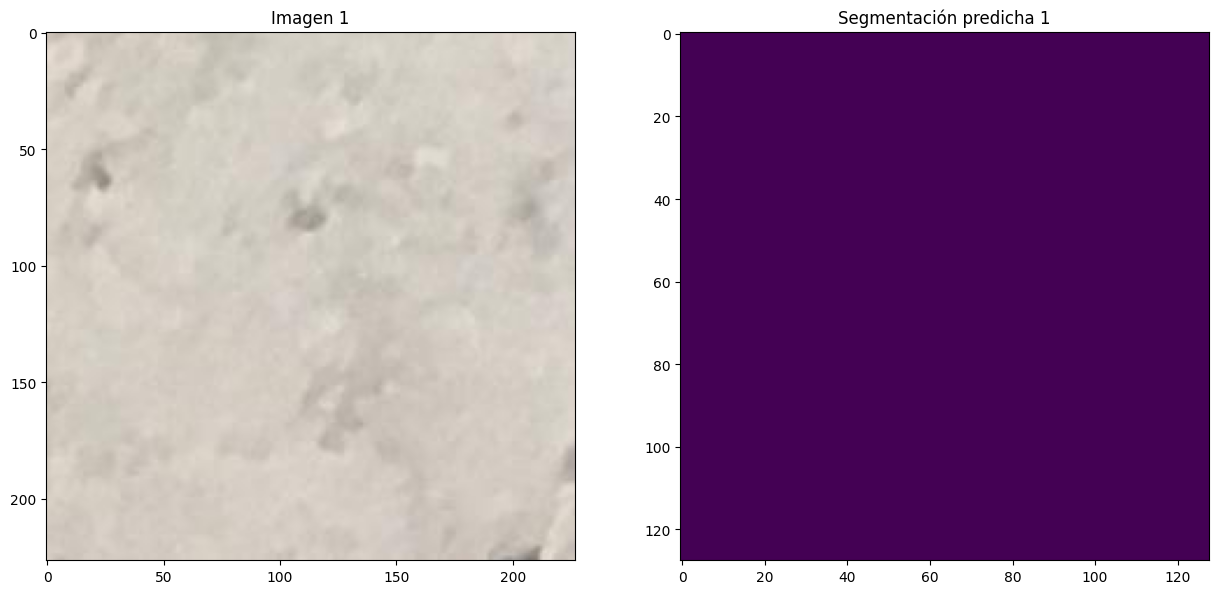

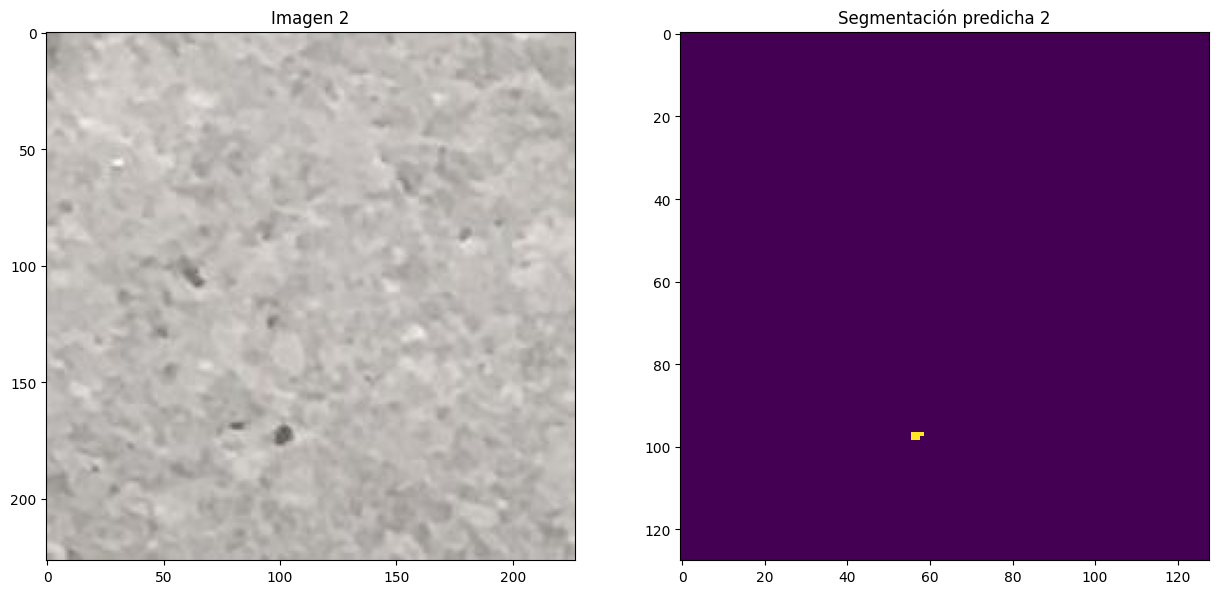

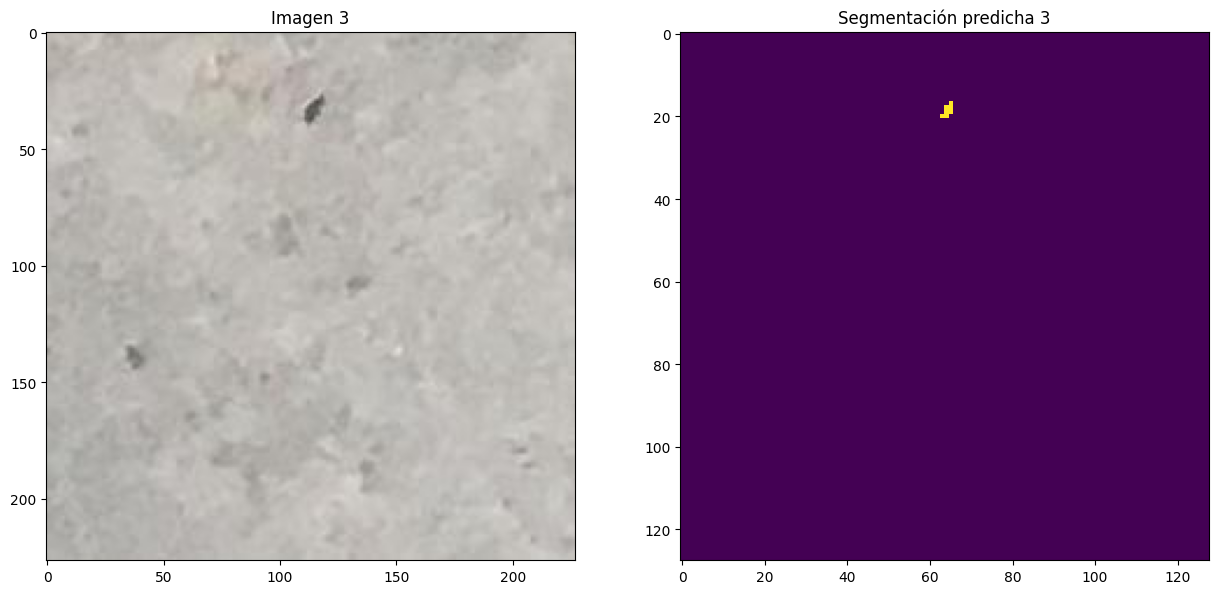

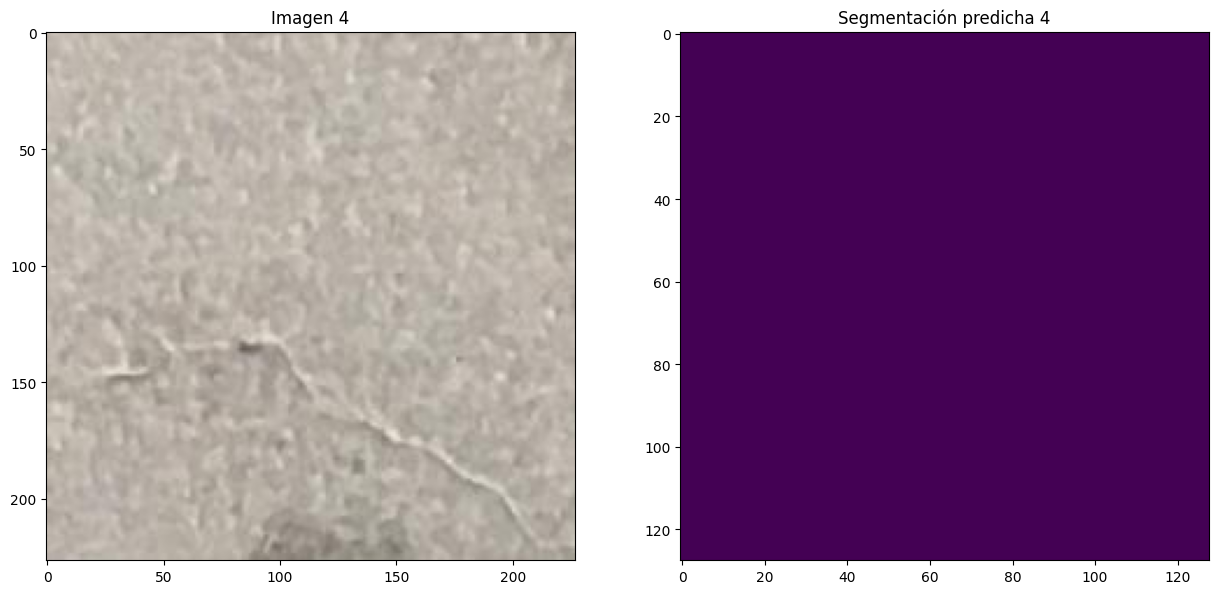

In [38]:
path1 = '/content/Negative/'  # Path de los nuevos datos, en esta carpeta hay cosas SIN "grietas"
path2 = '/content/labels/'
img, _ = LoadData(path1, path2) # Reciclo misma función de carga de antes, solo que la máscara ahora no tengo

show_images = 5        # Cantidad de imágenes a mostrar
for i in range(show_images):
    img_view  = imageio.imread(path1 + img[i])  # Leemos la imagen tal cual, para graficarla

    # Lectura de imagen y preprocesamiento para usarla en nuestro modelo (lo mismo que en la función para preprocesar)
    img_preprocesing = Image.open(path1 + img[i]).convert('RGB')
    img_preprocesing = img_preprocesing.resize((128,128))        # Rescalado, si usaron otro tamaño... cambiar acá
    img_preprocesing = np.reshape(img_preprocesing,(128,128,3))
    img_preprocesing = img_preprocesing/256.                     # Normalizado
    img_preprocesing = img_preprocesing[np.newaxis, ...]
    pred_y = unet.predict(img_preprocesing)                      # Prediccion del modelo
    # Transformaciones para poder graficar lo obtenido
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]

    # Ahora si, gráficas
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(img_view)
    arr[0].set_title('Imagen '+ str(i))
    arr[1].imshow(pred_mask)
    arr[1].set_title('Segmentación predicha '+ str(i))

Veo cuantas imagenes detecta con grieta y cuantas sin. Deberia detectar 0 con grietas.

In [ ]:
# Inicializar contadores
imagen_predicha_con_grieta_con_umbral = 0
imagen_predicha_sin_grieta_con_umbral = 0
imagen_predicha_con_grieta_sin_umbral = 0
imagen_predicha_sin_grieta_sin_umbral = 0
UMBRAL = 20 # Cantidad de pixels

cant_img_analisis = 500

for i in range(cant_img_analisis):

    # Lectura de imagen y preprocesamiento para usarla en nuestro modelo (lo mismo que en la función para preprocesar)
    img_preprocesing = Image.open(path1 + img[i]).convert('RGB')
    img_preprocesing = img_preprocesing.resize((128, 128))  # Rescalado, si usaron otro tamaño... cambiar acá
    img_preprocesing = np.reshape(img_preprocesing, (128, 128, 3))
    img_preprocesing = img_preprocesing / 256.  # Normalizado
    img_preprocesing = img_preprocesing[np.newaxis, ...]

    pred_y = unet.predict(img_preprocesing)  # Predicción del modelo
    # Transformaciones para poder graficar lo obtenido
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]

    # Verifico si hay grietas (con umbral)
    if np.sum(pred_mask) > UMBRAL:
        imagen_predicha_con_grieta_con_umbral += 1
    else:
        imagen_predicha_sin_grieta_con_umbral += 1

    # Verifico si hay grietas (sin umbral)
    if np.sum(pred_mask) > 0:
        imagen_predicha_con_grieta_sin_umbral += 1
    else:
        imagen_predicha_sin_grieta_sin_umbral += 1

In [41]:
# Muestro resultados de conteo (con umbral)
print("Imágenes con grietas (con umbral): {} ({}%)".format(imagen_predicha_con_grieta_con_umbral, (imagen_predicha_con_grieta_con_umbral/cant_img_analisis) * 100))
print("Imágenes sin grietas (con umbral): {} ({}%)".format(imagen_predicha_sin_grieta_con_umbral, (imagen_predicha_sin_grieta_con_umbral/cant_img_analisis) * 100))

# Muestro resultados de conteo (sin umbral)
print("Imágenes con grietas (sin umbral): {} ({}%)".format(imagen_predicha_con_grieta_sin_umbral, (imagen_predicha_con_grieta_sin_umbral/cant_img_analisis) * 100))
print("Imágenes sin grietas (sin umbral): {} ({}%)".format(imagen_predicha_sin_grieta_sin_umbral, (imagen_predicha_sin_grieta_sin_umbral/cant_img_analisis) * 100))

Imágenes con grietas (con umbral): 37 (7.3999999999999995%)
Imágenes sin grietas (con umbral): 463 (92.60000000000001%)
Imágenes con grietas (sin umbral): 106 (21.2%)
Imágenes sin grietas (sin umbral): 394 (78.8%)
